# benign confounders labeling for hateful memes

## init

In [ ]:
# mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
# hateful memes from MyDrive
!mkdir data
!unzip /content/drive/MyDrive/vilio/hateful_memes.zip -d data

In [ ]:
!git clone https://github.com/Noixas/Multimodal-NLP
!mkdir data/confounder
!cp Multimodal-NLP/dataset/upsampling_img_hash/image_confounders_id.json data/confounder
!cp Multimodal-NLP/dataset/upsampling_img_hash/image_confounders_id_dev_data.json data/confounder

Cloning into 'Multimodal-NLP'...
remote: Enumerating objects: 1799, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1799 (delta 1), reused 5 (delta 1), pack-reused 1794
Receiving objects: 100% (1799/1799), 188.67 MiB | 26.45 MiB/s, done.
Resolving deltas: 100% (942/942), done.
Checking out files: 100% (5687/5687), done.


In [ ]:
# modules
import glob
from itertools import chain
import json
import os
import signal
import sys
import time
from typing import Dict, List, Union
import warnings

import cv2
import dask.dataframe as dd
from dask.delayed import delayed
from IPython.display import clear_output
import matplotlib.pyplot as plt
# from matplotlib import image
import numpy as np
import pandas as pd
import pickle
import plotly.graph_objects as go
# from scipy.spatial import distance
from tqdm import tqdm, trange

%matplotlib inline
plt.style.use('dark_background')
warnings.simplefilter('ignore')

In [ ]:
# variables
data_root = "/content/data/hateful_memes"
img_path = "img"
jsons = []
txt_col, img_col, label_col = "text", "img", "label"
txt_cf_col, img_cf_col = "is_txt_confounder", "is_img_confounder"
txt_id_col, img_id_col = "txt_org_id", "img_org_id"
export_path = "/content/data/confounder"

## preprocessing

### jsonl

In [ ]:
def read_jsonls(path: str):
    """
    Read all jsonl files
    """

    def _read_jsonl(filename: str, usecols:List[str]=['id', 'img', label_col, 'text', "split"]):
        """
        Read one jsonl file w/ idenfitier
        """
        df = pd.read_json(filename, orient='records', lines=True)
        df["split"] = filename.split("/")[-1].split(".jsonl")[0]
        if label_col not in df.columns:
            df[label_col] = -1
        return df[usecols]

    jsons = glob.glob(f"{path}/*.jsonl")
    dd_list = [delayed(_read_jsonl)(json) for json in jsons]
    df = dd.from_delayed(dd_list).compute()
    return df

In [ ]:
df = read_jsonls(data_root)
df.head()

,id,img,label,text,split
0,42953,img/42953.png,0,its their character not their color that matters,train
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...,train
2,13894,img/13894.png,0,putting bows on your pet,train
3,37408,img/37408.png,0,i love everything and everybody! except for sq...,train
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h...",train


In [ ]:
# for compatibility with image filename
df["id"] = df["id"].astype('str').str.zfill(5)

## detecting benign confounder

### same-text-diff-image

In [ ]:
# flag duplicates
df_cnt = df[txt_col].value_counts().reset_index()
df_cnt.columns = [txt_col, "cnt"]
txt_dup = df_cnt.loc[df_cnt["cnt"]>=2, txt_col].tolist()
df[txt_cf_col] = 0
df.loc[df[txt_col].isin(txt_dup), txt_cf_col] = 1
df[txt_cf_col].value_counts()

0    6938
1    5602
Name: is_txt_confounder, dtype: int64

### same-image-diff-text

In [ ]:
# load duplicates
with open(os.path.join(export_path, "image_confounders_id.json"), "r") as f:
    img_dup = json.load(f)
with open(os.path.join(export_path, "image_confounders_id_dev_data.json"), "r") as f:
    img_dup_dev = json.load(f)

In [ ]:
# make it compatible with filename
img_dup = [str(img).zfill(5) for img in img_dup]
img_dup_dev = [str(img).zfill(5) for img in img_dup_dev]
img_dup_all = img_dup+img_dup_dev

<Figure size 432x288 with 0 Axes>

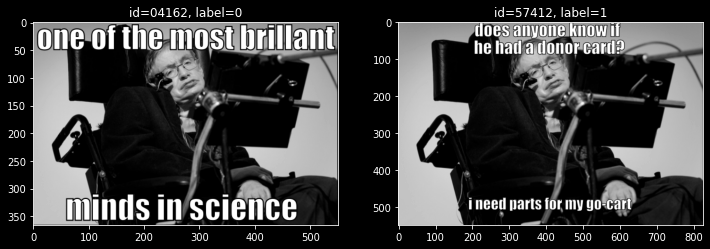

In [ ]:
# check duplicates
_idx, _idx2 = 1, 2

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2,figsize=(12,16)) 
for i,idx in enumerate([_idx,_idx2]):
    # use the created array to output your multiple images.
    img_id = img_dup[idx]
    img_path = f"img/{img_id}.png"
    label = df.loc[df["id"]==img_id, label_col].values[0]
    img = cv2.imread(os.path.join(data_root, img_path), cv2.IMREAD_GRAYSCALE)
    axarr[i].set_title(f"id={img_id}, label={label}")
    axarr[i].imshow(img, cmap="gray")

In [ ]:
# flag duplicates
df[img_cf_col] = 0
df.loc[df["id"].isin(img_dup_all), img_cf_col] = 1
df[img_cf_col].value_counts()

0    9970
1    2570
Name: is_img_confounder, dtype: int64

### explore confounder

In [ ]:
# text*image confounder cross aggregates
df.groupby([txt_cf_col, img_cf_col])["id"].nunique()

is_txt_confounder  is_img_confounder
0                  0                    5481
                   1                    1457
1                  0                    4266
                   1                     936
Name: id, dtype: int64

In [ ]:
'''
0-1, 1-0 should be image / text confounder, respectively
1-1 should be original (hateful?) image
'''

In [ ]:
# text*image confounder cross aggregates
df.groupby([label_col, txt_cf_col, img_cf_col])["id"].nunique()

label  is_txt_confounder  is_img_confounder
-1     0                  0                     988
       1                  0                    2012
 0     0                  0                    3044
                          1                    1022
       1                  0                    1635
                          1                     173
 1     0                  0                    1449
                          1                     435
       1                  0                     619
                          1                     763
Name: id, dtype: int64

In [ ]:
'''
text hateful: 1-1-[0,1]
text benign: 1-0-[0,1]
image hateful: 1-[0,1]-1
image benign: 0-[0,1]-1
-> once group of confounders is identified, can compare within group
'''

## grouping benign confounder

### text

In [ ]:
# select perfect duplicate
def duplicates_flagger(data:pd.DataFrame, data2:pd.DataFrame, mod_col:str=txt_col, label_col:str=label_col):
    def duplicate_flagger(ip1:Dict[str, Union[str, int]], ip2:Dict[str, Union[str, int]], mode:str="perfect"):
        """
        Compare txt/txt or img/img to check duplicate
        """
        if mode=="perfect":
            if ip1["data"]==ip2["data"]:
                out = ip2["id"]
            else:
                out = "Not hit"
        return out
    """
    Flagging duplicates out of single modality
    """
    if mod_col=="text":
        data_ip = data.copy()
        data_ip2 = data2[data2[label_col]==1].drop_duplicates(subset=mod_col)
    else:
        data_ip = data.copy()
    dup_ids = []
    for i, ip in tqdm(zip(data_ip["id"], data_ip[mod_col])):
        data_dict = {"id": i, "data": ip}
        cnt = 0
        for i2, ip2 in zip(data_ip2["id"], data_ip2[mod_col]):
            data_dict2 = {"id": i2, "data": ip2}
            dup_id = duplicate_flagger(data_dict, data_dict2)
            if dup_id!="Not hit":
                dup_ids.append(dup_id)
                break
            else:
                cnt += 1
                if cnt==len(data_ip2):
                    dup_ids.append(dup_id)
                else:
                    pass
    return dup_ids

In [ ]:
# df_txt_cf = df[df[txt_cf_col]==1].copy()
df_txt_cf = df[df[txt_cf_col]==1].sort_values(by=txt_col)
df_txt_cf[txt_id_col] = duplicates_flagger(df_txt_cf, df_txt_cf)

5602it [00:09, 563.68it/s]


In [ ]:
df_txt_cf[txt_id_col].value_counts().head()

Not hit    2936
75231        19
28957        15
57982        15
16734        14
Name: txt_org_id, dtype: int64

In [ ]:
fig = go.Figure()
df_plot = df_txt_cf[df_txt_cf[txt_id_col]!="Not hit"]
df_cnt = df_plot.loc[df_plot[txt_id_col]!="Not hit", txt_id_col].value_counts().reset_index()
fig.add_trace(go.Histogram(x=df_cnt[txt_id_col], name=f"id count", histnorm='probability', bingroup=1))
fig.show()

### image

#### annotation

In [ ]:
# img_dup_all = img_dup_all[:20]
# print(len(img_dup_all))

In [ ]:
def signal_handler(signal, frame):
    print('Aborted')
    sys.exit(0)

In [ ]:
signal.signal(signal.SIGINT, signal_handler)

num_img_org = len(img_dup_all)
cluster = 0
try:
    with open("/content/drive/MyDrive/annotation/hm_img_confounder.pickle", "rb") as f:
        clusters = pickle.load(f)
except Exception as e:
    clusters = []
if len(clusters)==0:
    cluster = 0
else:
    cluster = max(clusters)
done = len(clusters)
num_img = num_img_org-done
for idx in trange(num_img//2):
# for idx in trange(5):
    # check duplicates
    _idx, _idx2 = done+2*idx, done+2*idx+1

    if done:
        img_id = img_dup_all[idx]
        img_path = f"img/{img_id}.png"
        label = df.loc[df["id"]==img_id, label_col].values[0]
        img = cv2.imread(os.path.join(data_root, img_path), cv2.IMREAD_GRAYSCALE)
    
    plt.figure()
    
    # show images
    ## subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(1,2,figsize=(12,16)) 
    for i,i2 in enumerate([_idx,_idx2]):
        ## use the created array to output your multiple images.
        img_id = img_dup_all[i2]
        img_path = f"img/{img_id}.png"
        label = df.loc[df["id"]==img_id, label_col].values[0]
        img = cv2.imread(os.path.join(data_root, img_path), cv2.IMREAD_GRAYSCALE)
        axarr[i].set_title(f"id={img_id}, label={label}")
        axarr[i].imshow(img, cmap="gray")
    plt.show()

    with open("/content/drive/MyDrive/annotation/hm_img_confounder.pickle", "wb") as f:
        pickle.dump(clusters, f)

    ## 1 if image is new, else 0
    left = input("LEFT image new?: ")
    right = input("RIGHT image new?: ")
    for result in [left, right]:
        if int(result):
            cluster += 1
        else:
            pass
        clusters.append(cluster)

    time.sleep(1)
    clear_output(wait=True)
with open("/content/drive/MyDrive/annotation/hm_img_confounder.pickle", "wb") as f:
    pickle.dump(clusters, f)

100%|██████████| 116/116 [11:36<00:00,  6.00s/it]


In [ ]:
# # check result
# arr_clusters = np.array(clusters)
# arr_img = np.array(img_dup_all)[:len(arr_clusters)]
# for idx in sorted(list(set(clusters)))[1000:1500]:
#     print(idx)
#     img_cluster = arr_img[arr_clusters==idx]
#     if len(img_cluster)==1:
#         continue
#     plt.figure()
#     f, axarr = plt.subplots(1,len(img_cluster),figsize=(4*len(img_cluster),6*len(img_cluster))) 
#     for i,img_id in enumerate(img_cluster):
#         img_path = f"img/{img_id}.png"
#         label = df.loc[df["id"]==img_id, label_col].values[0]
#         img = cv2.imread(os.path.join(data_root, img_path), cv2.IMREAD_GRAYSCALE)
#         axarr[i].set_title(f"id={img_id}, label={label}, cluster={idx}")
#         axarr[i].imshow(img, cmap="gray")
#     plt.show()

In [1]:
# # check result
# ## single-image cluster + representative image
# mode = "single"
# arr_clusters = np.array(clusters)
# arr_img = np.array(img_dup_all)[:len(arr_clusters)]
# for idx in sorted(list(set(clusters))):
#     img_cluster = arr_img[arr_clusters==idx]
#     if (mode=="single" and len(img_cluster)==1) or (mode!="single" and len(img_cluster)>1):
#         print(idx)
#         img_id = img_cluster[0]
#         img_path = f"img/{img_id}.png"
#         label = df.loc[df["id"]==img_id, label_col].values[0]
#         img = cv2.imread(os.path.join(data_root, img_path), cv2.IMREAD_GRAYSCALE)
#         plt.title(f"id={img_id}, label={label}, cluster={idx}, num_img={len(img_cluster)}")
#         plt.imshow(img, cmap="gray")
#         plt.show()
#     else:
#         pass

In [ ]:
# collect
arr_clusters,arr_clusters2 = np.array(clusters),np.array(clusters)
arr_clusters2[arr_clusters==98] = 106
arr_clusters2[arr_clusters==101] = 110
arr_clusters2[arr_clusters==495] = 496
clusters = arr_clusters2.tolist()
with open("/content/drive/MyDrive/annotation/hm_img_confounder.pickle", "wb") as f:
    pickle.dump(clusters, f)

In [2]:
# # check result
# ## single-image cluster + representative image
# mode = "multiple"
# arr_clusters = np.array(clusters)
# arr_img = np.array(img_dup_all)[:len(arr_clusters)]
# for idx in sorted(list(set(clusters))):
#     img_cluster = arr_img[arr_clusters==idx]
#     if (mode=="single" and len(img_cluster)==1) or (mode!="single" and len(img_cluster)>1):
#         print(idx)
#         img_id = img_cluster[0]
#         img_path = f"img/{img_id}.png"
#         label = df.loc[df["id"]==img_id, label_col].values[0]
#         img = cv2.imread(os.path.join(data_root, img_path), cv2.IMREAD_GRAYSCALE)
#         plt.title(f"id={img_id}, label={label}, cluster={idx}, num_img={len(img_cluster)}")
#         plt.imshow(img, cmap="gray")
#         plt.show()
#     else:
#         pass

In [ ]:
# collect
arr_clusters,arr_clusters2 = np.array(clusters),np.array(clusters)
arr_clusters2[arr_clusters==620] = 617
clusters = arr_clusters2.tolist()
with open("/content/drive/MyDrive/annotation/hm_img_confounder.pickle", "wb") as f:
    pickle.dump(clusters, f)

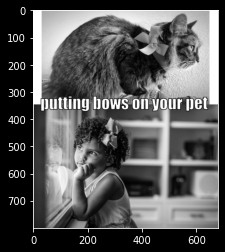

In [ ]:
# add cluster for last image
## check if it's identical to -2
img_id = img_dup_all[-1]
img_path = f"img/{img_id}.png"
label = df.loc[df["id"]==img_id, label_col].values[0]
img = cv2.imread(os.path.join(data_root, img_path), cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap="gray")

In [ ]:
# add cluster for last image
clusters.append(clusters[-1])
with open("/content/drive/MyDrive/annotation/hm_img_confounder.pickle", "wb") as f:
    pickle.dump(clusters, f)

In [ ]:
len(img_dup_all),len(clusters)

(2393, 2393)

#### label to dataframe

In [ ]:
with open("/content/drive/MyDrive/annotation/hm_img_confounder.pickle", "rb") as f:
    clusters = pickle.load(f)

In [ ]:
# prep image clustered df
df_img_cf = pd.DataFrame([img_dup_all, clusters]).T
df_img_cf.columns = ["img_id", "img_cluster"]
# remove single-image cluster
df_img_cf_cnt = df_img_cf.groupby("img_cluster").count().reset_index()
single_cluster = df_img_cf_cnt.loc[df_img_cf_cnt["img_id"]==1, "img_cluster"].tolist()
print(len(df_img_cf))
df_img_cf = df_img_cf[~df_img_cf["img_cluster"].isin(single_cluster)]
print(len(df_img_cf))
# merge label
df_img_cf = df_img_cf.merge(df[["id", "label"]].drop_duplicates().set_index("id"), left_on="img_id", right_index=True)
df_img_cf_cnt = df_img_cf.groupby("img_cluster")["label"].sum().reset_index()
all_negatives = df_img_cf_cnt.loc[df_img_cf_cnt["label"]==0, "img_cluster"].tolist()
print(len(df_img_cf))
df_img_cf = df_img_cf[~df_img_cf["img_cluster"].isin(all_negatives)]
print(len(df_img_cf))
# add id by labels
## id of positive image, youngest if multiple
df_img_cf_pos = df_img_cf[df_img_cf["label"]==1].groupby("img_cluster")["img_id"].min().reset_index()
df_img_cf = df_img_cf.merge(df_img_cf_pos[["img_cluster", "img_id"]].rename({"img_id": img_id_col}, axis=1).set_index("img_cluster"), left_on="img_cluster", right_index=True)
df_img_cf.head()
# df_img_cf_pos.head()
# df_img_cf_cnt.head()

2393
2362
2362
2357


,img_id,img_cluster,label,img_org_id
0,32768,0,0,57412
1,04162,0,0,57412
2,57412,0,1,57412
3,94678,0,0,57412
4,57346,1,0,46978


### group for evaluation

In [ ]:
len(df), len(df_img_cf), len(df_txt_cf)

(12540, 2357, 5602)

In [ ]:
print(df.columns)
print(df_img_cf.columns)
print(df_txt_cf.columns)

Index(['id', 'img', 'label', 'text', 'split', 'is_txt_confounder',
       'is_img_confounder'],
      dtype='object')
Index(['img_id', 'img_cluster', 'label', 'img_org_id'], dtype='object')
Index(['id', 'img', 'label', 'text', 'split', 'is_txt_confounder',
       'is_img_confounder', 'txt_org_id'],
      dtype='object')


In [ ]:
df_merged = df[["id", "split", "label"]].merge(df_img_cf[["img_id", "img_org_id"]].set_index("img_id"),left_on="id", right_index=True, how="left").fillna("No Confounder")
df_merged = df_merged.merge(df_txt_cf[["id", "txt_org_id"]].set_index("id"),left_on="id", right_index=True, how="left").fillna("No Confounder")

In [ ]:
df_merged.groupby(['split', 'label'])["img_org_id"].nunique()

split        label
dev_seen      0        85
              1        85
dev_unseen    0        85
              1        85
test_seen    -1         1
test_unseen  -1         1
train         0       807
              1       810
Name: img_org_id, dtype: int64

In [ ]:
df_merged.groupby(['split', 'label'])["txt_org_id"].nunique()

split        label
dev_seen      0        82
              1       206
dev_unseen    0        80
              1       198
test_seen    -1        39
test_unseen  -1        33
train         0       707
              1       824
Name: txt_org_id, dtype: int64

In [ ]:
df_merged.to_parquet("/content/drive/MyDrive/annotation/confounders.parquet", index=False)

# EOS